In [64]:
import math
import numpy as np
import numpy.linalg
        

In [86]:

# Given a pixel's coordinates, calculate the distortion based on the height 
# and width of the input image. 
class Distorter:
    
    ''' Stores the height and width of the input image and the size of the 
    convolution kernel.'''
    def __init__(self, width, height, conv_size):
        self.W = width
        self.H = height
        self.KERNEL_SIZE = conv_size
        self.R = self.computeR(conv_size)

    # Computes the relative sampling positions as a matrix given the required size of the square convolution kernel.
    # Assumes that the size of the kernel is odd so that there is a center.
    def computeR(self, size):
        if (size % 2 == 0):
            return None

        upper_lim = size // 2
        lower_lim = -1 * upper_lim

        return np.array([[(i, j) for j in range(lower_lim, upper_lim + 1)] for i in range(lower_lim, upper_lim + 1)])    
    
        
    # Returns the latitude and longitude of given coordinates.
    def long_and_lat_2d(self, x, y):
        long = (x -(self.W / 2)) * ((2 * math.pi) / self.W) 
        lat = (self.H*0.5 - y) * (math.pi / self.H) 
        return long, lat
    
    # Backprojects, obtaining a latitude and longitude from the spherical domain.
    def long_and_lat_3d(self, x, y, z):
        long = 0
        if x == 0:
            long = math.pi / 2
        elif long > 0:
            math.atan(z / x)
        else:
            math.atan(z / x) + math.pi
        
        lat = math.asin(y)
        return long, lat
    
    # Returns the spherical coordinates of a given latitude and longitude.
    def spherical_coords(self, long, lat):
        xu = math.cos(lat) * math.sin(long)
        yu = math.sin(lat)
        zu = math.cos(lat) * math.cos(long)
        
        return np.array([xu, yu, zu])
    
    # Computes the direction vectors that define a tangent plane to the given spherical point, tx and ty.
    # spherical_coords must be a numpy array.
    def tangent_plane_vectors(self, spherical_coords):
        tx = self.normalize(np.cross(np.array([0, 1, 0]), spherical_coords))
        ty = self.normalize(np.cross(spherical_coords, tx))

        return tx, ty
    
    def normalize(self, vector):
        norm=np.linalg.norm(vector, ord=1)
        if norm==0:
            norm=np.finfo(vector.dtype).eps
        return vector/norm
    
    # Computes the sampling grid.
    def sampling_grid(self, tx, ty):
        # Spatial resolution - distance between elements
        res = math.tan((2 * math.pi) / self.W)
        
        # Computes the sampling grid elements and locations on the sampling grid.
        sampling_grid_locations = np.empty(shape=(self.R.shape[0], self.R.shape[1], 3))
        for i in range(0, self.R.shape[0]):
            for j in range(0, self.R.shape[1]):
                r = self.R[i][j]        
                sampling_grid_element = res * (tx * r[0] + ty * r[1])
                sampling_grid_locations[i, j] = res + sampling_grid_element
        return sampling_grid_locations
    
    # Backpropogates point locations from the sampling grid to the equirectangular domain.
    def backpropogate(self, sampling_grid_locations):
        offsets = np.zeros(shape=(sampling_grid_locations.shape[0], sampling_grid_locations[1], 2))
        
        # For each sampling grid element compute their equirectangular plane coordinates
        for i in range(0, sampling_grid_locations.shape[0]):
            for j in range(0, sampling_grid_locations.shape[1]):
                # Compute the longitude and latitude
                new_long, new_lat = long_and_lat_3d(sampling_grid_locations)
                x = ((new_long / (2*math.pi)) + 0.5) * self.W
                y = (0.5 - (new_lat / math.pi)) * self.H
                offsets[i][j] = [x, y]
        
        return offsets

    
      
        
distorter = Distorter(200, 200, 3)
print("\n___________________________________________________")
print("Test for compute R: \n" + str(distorter.computeR(3)))

print("\n___________________________________________________")
long, lat = distorter.long_and_lat_2d(0, 0)
print(f"Test for latitude and longitude (0, 0): {long}, {lat}")
long2, lat2 = distorter.long_and_lat_2d(200, 200)
print(f"Test for latitude and longitude (200, 200): {long2}, {lat2}")
long3, lat3 = distorter.long_and_lat_2d(100, 100)
print(f"Test for latitude and longitude (100, 100): {long3}, {lat3}")

print("\n__________________________________________________")
sphere_coords = distorter.spherical_coords(long, lat)
print(f"Test for spherical coordinates ({long}, {lat}): {sphere_coords}")
sphere_coords2 = distorter.spherical_coords(long2, lat2)
print(f"Test for spherical coordinates ({long2}, {lat2}): {sphere_coords2}")
sphere_coords3 = distorter.spherical_coords(long3, lat3)
print(f"Test for spherical coordinates ({long3}, {lat3}): {sphere_coords3}")

print("\n__________________________________________________")
tx, ty = distorter.tangent_plane_vectors(sphere_coords)
print(f"Tangent plane vectors are {tx}, {ty}")
tx2, ty2 = distorter.tangent_plane_vectors(sphere_coords2)
print(f"Tangent plane vectors are {tx2}, {ty2}")
tx3, ty3 = distorter.tangent_plane_vectors(sphere_coords3)
print(f"Tangent plane vectors are {tx3}, {ty3}")

print("\n__________________________________________________")
sampling_grid = distorter.sampling_grid(tx, ty)
print(f"Sampling grid vectors for tx and ty being {tx} and {ty}: \n {sampling_grid}\n")
sampling_grid2 = distorter.sampling_grid(tx2, ty2)
print(f"Sampling grid vectors for tx and ty being {tx2} and {ty2}: \n {sampling_grid2}\n")
sampling_grid3 = distorter.sampling_grid(tx3, ty3)
print(f"Sampling grid vectors for tx and ty being {tx3} and {ty3}: \n {sampling_grid3}\n")


print("\n__________________________________________________")
offsets = distorter.backpropogate(sampling_grid)
print(f"Offsets of elements to be sampled for (0, 0): \n {offsets}")
offsets2 = distorter.backpropogate(sampling_grid2)
print(f"Offsets of elements to be sampled for (200, 200): \n {offsets2}")
offsets3 = distorter.backpropogate(sampling_grid3)
print(f"Offsets of elements to be sampled for (100, 100): \n {offsets3}")


___________________________________________________
Test for compute R: 
[[[-1 -1]
  [-1  0]
  [-1  1]]

 [[ 0 -1]
  [ 0  0]
  [ 0  1]]

 [[ 1 -1]
  [ 1  0]
  [ 1  1]]]

___________________________________________________
Test for latitude and longitude (0, 0): -3.1415926535897936, 1.5707963267948968
Test for latitude and longitude (200, 200): 3.1415926535897936, -1.5707963267948968
Test for latitude and longitude (100, 100): 0.0, 0.0

__________________________________________________
Test for spherical coordinates (-3.1415926535897936, 1.5707963267948968): [-5.17211691e-32  1.00000000e+00  1.60812265e-16]
Test for spherical coordinates (3.1415926535897936, -1.5707963267948968): [ 5.17211691e-32 -1.00000000e+00  1.60812265e-16]
Test for spherical coordinates (0.0, 0.0): [0. 0. 1.]

__________________________________________________
Tangent plane vectors are [ 1.0000000e+00 -0.0000000e+00  3.2162453e-16], [ 3.21624530e-16  1.60812265e-16 -1.00000000e+00]
Tangent plane vectors are [ 1.

TypeError: only integer scalar arrays can be converted to a scalar index

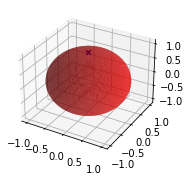

In [58]:
import matplotlib.pyplot as plt
from numpy import sin, cos, pi
# Create a sphere
r = 1
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
x = r*sin(phi)*cos(theta)
y = r*sin(phi)*sin(theta)
z = r*cos(phi)

#Set colours and render
fig = plt.figure()
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(
    x, y, z,  rstride=1, cstride=1, color='r', alpha=0.6, linewidth=0)

ax.scatter(sphere_coords3[0], sphere_coords3[1], sphere_coords3[2], color='b', marker='x')


-3.216245299353273e-16